# LSTM Bot

## Project Overview

In this project, I build a chatbot that you can converse with at the command line. The chatbot uses a Sequence to Sequence text generation architecture with an LSTM as it's memory unit. It uses pretrained word embeddings to improve the performance of the model.

---



A sequence to sequence model (Seq2Seq) has two components:
- An Encoder consisting of an embedding layer and LSTM unit.
- A Decoder consisting of an embedding layer, LSTM unit, and linear output unit.

The Seq2Seq model works by accepting an input into the Encoder, passing the hidden state from the Encoder to the Decoder, which the Decoder uses to output a series of token predictions.

## Dependencies

- Pytorch
- Numpy
- Pandas
- NLTK
- Gzip
- Gensim


__Downloads__

In [1]:
%pip install torchdata
%pip install Cython
%pip install typing-extensions --upgrade
%pip install torch --upgrade
%pip install torchtext==0.9.0

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 4.6 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 887.5 MB 5.7 kB/s  eta 0:00:01
     |████████████████████████████████| 849 kB 34.2 MB/s eta 0:00:01
     |████████████████████████████████| 317.1 MB 23 kB/s s eta 0:00:01               | 71.7 MB 36.8 MB/s eta 0:00:07
     |████████████████████████████████| 557.1 MB 6.1 kB/s  eta 0:00:01
     |████████████████████████████████| 21.0 MB 36.3 MB/s eta 0:00:01
ERROR: torchvision 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.13.1 which is incompatible.
ERROR: torchtext 0.12.0 has requirement torch==1.11.0, but you'll have torch 1.13.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-package

_Restart the kernel_

In [2]:
# initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time
import math
import random
import re
import unicodedata
import nltk
import string

import torchtext
import torch
import torch.optim as optim
import torch.nn as nn
import gensim.downloader
import torch.nn.functional as F

In [3]:
# dataset download
train, test = torchtext.datasets.SQuAD1("root")

The Squad 1 dataset contains 100k+ questions and answers based on over 500 articles. More information can be found [here](https://rajpurkar.github.io/SQuAD-explorer/).

In [4]:
# check number of rows
print(f"Number of training data rows: {train.num_lines}")
print(f"Number of test data rows: {test.num_lines}")

Number of training data rows: 87599
Number of test data rows: 10570


In [5]:
# print out example question
for context, question, answer, answer_start in train:
    print(f"Question: {question}")
    print(f"Answer: {answer[0]}")
    break

Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer: Saint Bernadette Soubirous


In [6]:
# extract data into dataframe
def convert_to_df(iterator):

    questions, answers = [], []

    for line in iterator:
        _, question, answer, _ = line


        questions.append(question)
        answers.append(answer[0])

    data_dict = {
        "question": questions,
        "answer": answers,
    }

    df = pd.DataFrame(data_dict)
    
    return df

df_train = convert_to_df(train)
df_test = convert_to_df(test)

_Data Checks_

In [7]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87598 entries, 0 to 87597
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  87598 non-null  object
 1   answer    87598 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB
None


In [8]:
# get a feel for what the data looks like
df_train.sample(10)

,question,answer
79532,How many tourist visas were granted in 2003?,"300,000"
39645,Which CBS correspondant graduated from The Med...,Richard Threlkeld
68742,Name the main airport?,Philadelphia International Airport (PHL)
11391,What year did Terminator Genisys debut?,2015
33264,Which town was the site of General von Steinme...,Spicheren
17007,What lines comprise the Beijing-Shanghai (Jing...,the old Jinpu and Huning Railways
35625,In what year was Athanasius consecrated?,326
49194,What were the followers of Jan Hus called?,Hussites
28425,What team did Barcelona beat to win La Liga fo...,Real Madrid
7003,For how many seasons were the three original j...,eight


__Build a Vocab__

In [9]:
SOS_token = 0
EOS_token = 1

class Vocab:
    """ This vocabulary class cleans and indexes words.
    """
    def __init__(self, name):
        self.name = name
        self.word2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2word = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.word2count = {}
        self.n_words = 2 # count SOS and EOS
    
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    
    # Index words in our vocabulary
    def addWord(self, word):
        if word not in self.word2index: # if word not in index
            self.word2index[word] = self.n_words # add word and word no to words dictionary
            self.word2count[word] = 1 # initialise word count
            self.index2word[self.n_words] = word # add word to index
            self.n_words +=1
        else:
            self.word2count[word] += 1 # increment word count

In [10]:
stemmer = nltk.stem.snowball.SnowballStemmer("english")

def normalizeString(s):
    s = s.lower().split()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def prepare_text(sentence):
    sentence = ''.join([ch.lower() for ch in sentence if ch not in string.punctuation])
    sentence = ' '.join(stemmer.stem(w) for w in sentence.split())
    tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sentence)
    return tokens

df_train["question"] = df_train["question"].apply(prepare_text)
df_train["answer"] = df_train["answer"].apply(prepare_text)

In [12]:
def getPairs(df):
    # convert df to list of pairs
    temp1 = df['question'].apply(lambda x: " ".join(x) ).to_list()
    temp2 = df['answer'].apply(lambda x: " ".join(x) ).to_list()
    return [list(i) for i in zip(temp1, temp2)]

pairs = getPairs(df_train)
print(f"read {len(pairs)} pairs")

# filter to shorter pairs
MAX_LENGTH = 10
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]
pairs = filterPairs(pairs)
print(f"filtered to {len(pairs)} pairs")

# reduce dataset size to reduce training time
dataset_size = 2500
pairs = pairs[:dataset_size]
print(f"final number of pairs: {len(pairs)}")

read 87598 pairs
filtered to 40716 pairs
final number of pairs: 2500


In [14]:
# print random sentence and answer
random_pair = random.choice(pairs)
print(random_pair)

['what is a cultur phenomenon', 'art']


In [15]:
# create and populate vocab object
vocab_questions = Vocab("questions")
vocab_answers = Vocab("answers")
for question, answer in pairs:
    vocab_questions.addSentence(question)
    vocab_answers.addSentence(answer)
    
# check words added
print(f"Added {vocab_questions.n_words} question words")
print(f"Added {vocab_answers.n_words} answer words")

Added 2816 question words
Added 2655 answer words


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def indexesFromSentence(sentence, vocab):
    # returns a list of indices representing the input sentence
    return [vocab.word2index[word] for word in sentence.split(" ")]

def tensorFromSentence(sentence, vocab):
    # appends a EOS token and returns a tensor list of indices representing the input sentence
    indexes = indexesFromSentence(sentence, vocab)
    indexes.append(EOS_token)
    # view(-1, 1) specifies that we want the shape of 1 column and whatever number of rows to achieve that shape
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    # combines the function above and returns question and answer tensors
    question_tensor = tensorFromSentence(pair[0], vocab_questions)
    answer_tensor = tensorFromSentence(pair[1], vocab_answers)
    return (question_tensor, answer_tensor)

# test functions
random_pair = random.choice(pairs)
print(random_pair)
tensorsFromPair(random_pair)

['what new york thoroughfar is museum mile locat on', 'fifth avenu']


(tensor([[   2],
         [ 451],
         [2236],
         [2466],
         [   3],
         [ 140],
         [2300],
         [ 274],
         [  79],
         [   1]], device='cuda:0'),
 tensor([[1528],
         [2240],
         [   1]], device='cuda:0'))

__Download the gensim embedding__

In [17]:
glove_vectors = gensim.downloader.load("glove-wiki-gigaword-300")

embedding_dim = glove_vectors.vectors.shape[1]
print(embedding_dim)

[==================================================] 100.0% 376.1/376.1MB downloaded
300


_Explore embedding model_

In [18]:
glove_vectors.most_similar("man")

[('woman', 0.6998663544654846),
 ('person', 0.6443442106246948),
 ('boy', 0.6208277940750122),
 ('he', 0.5926738381385803),
 ('men', 0.5819568634033203),
 ('himself', 0.5810033082962036),
 ('one', 0.5779521465301514),
 ('another', 0.5721587538719177),
 ('who', 0.5703631639480591),
 ('him', 0.5670831203460693)]

In [19]:
glove_vectors["man"]

array([-0.29784  , -0.13255  , -0.14505  , -0.22752  , -0.027429 ,
        0.11005  , -0.039245 , -0.0089607, -0.18866  , -1.1213   ,
        0.34793  , -0.30056  , -0.50103  , -0.031383 , -0.032185 ,
        0.018318 , -0.090429 , -0.14427  , -0.14306  , -0.057477 ,
       -0.020931 ,  0.56276  , -0.018557 ,  0.15168  , -0.25586  ,
       -0.081564 ,  0.2803   , -0.10585  , -0.16777  ,  0.21814  ,
       -0.11845  ,  0.56475  , -0.12645  , -0.062461 , -0.68043  ,
        0.10507  ,  0.24793  , -0.20249  , -0.30726  ,  0.42815  ,
        0.38378  , -0.19371  , -0.075951 , -0.058287 , -0.067195 ,
        0.2192   ,  0.56116  , -0.28156  , -0.13705  ,  0.45754  ,
       -0.14671  , -0.18562  , -0.074146 ,  0.60737  ,  0.07952  ,
        0.41023  ,  0.18377  , -0.08532  ,  0.43795  , -0.34727  ,
        0.2077   ,  0.50454  ,  0.40244  ,  0.1095   , -0.48078  ,
       -0.22372  , -0.54619  , -0.20782  ,  0.13751  , -0.16206  ,
       -0.24835  ,  0.17124  ,  0.037355 ,  0.14547  , -0.0562

_Create weights matrix to map each word embedding to the word in the vocab_

In [20]:
def create_vocab_weight_matrix(vocab, embed_dim=embedding_dim, glove=glove_vectors):

    matrix_len = len(vocab.word2index) # length of vocab
    weights_matrix = np.zeros((matrix_len, embed_dim)) # initialise empty weights matrix

    words_found = 0
    # add words to weights matrix
    for i, word in enumerate(vocab.word2index):
        try:
            weights_matrix[i] = glove[word] # map to glove vector word embedding
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, )) # insert random weights
            
    return weights_matrix
            
vocab_questions_matrix = create_vocab_weight_matrix(vocab_questions)
vocab_answers_matrix = create_vocab_weight_matrix(vocab_answers)

# check
print(vocab_questions_matrix[vocab_questions.word2index["who"]] - glove_vectors["who"])
print(vocab_answers_matrix[vocab_answers.word2index["the"]] - glove_vectors["the"])

__Define Model Structure__

In [22]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, embedding_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        # copy loaded weights matrix into embedding weights - a vector representation of the model word inputs
        self.embedding.weight.data.copy_(torch.from_numpy(vocab_questions_matrix))
        # initialise lstm to take input dimension of embedding size and output hidden dimension
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers)
        
    
    def forward(self, src, hidden, cell_state):
        
        '''
        Inputs: src, the src vector
        Outputs: output, the encoder outputs
                hidden, the hidden state
                cell, the cell state
        '''
        # src shape: (seq_length, batch_size)
        embedding = self.embedding(src).view(1, 1, -1)
        # embedding shape: (seq_length, batch_size, embedding_size)
        output, (hidden, cell) = self.lstm(embedding, (hidden, cell_state)) # output, hidden and cell state
        
        return output, hidden, cell
    
    def initHidden(self):# initialise zero tensor with shape (1, 1, hidden_size)
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

class Decoder(nn.Module):
      
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):
        super(Decoder, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size # length of vocab
        self.num_layers = num_layers        
        
        # self.embedding provides a vector representation of the target to our model
        self.embedding = nn.Embedding(output_size, embedding_size)
        # self.embedding.weight.data.copy_(torch.from_numpy(vocab_answers_matrix))
        # self.lstm, accepts the embeddings and outputs a hidden state
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers)
        # self.output, predicts on the hidden state via a linear output layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, trg, hidden, cell):
        
        '''
        Inputs: trg, the target vector
        Outputs: predictions, the predictions
                hidden, the hidden state
                cell, the cell state
        '''
        # shape of src is batch_size, but we want (1, batch_size)
        # we want batch_size batches of a single word at a time
        trg = trg.unsqueeze(0) # add one dimension
        embedding = self.embedding(trg).view(1, 1, -1)
        # embedding shape: (1, batch_size, embedding_size)
        output, (hidden, cell) = self.lstm(embedding, (hidden, cell))
        # shape of outputs: (1, batch_size, hidden_size)
        predictions = self.softmax(self.fc(output[0]))
        # shape of predictions: (1, batch_size, length_of_vocab)        
        
        return predictions, hidden, cell
    
    def initHidden(self): # initialise zero tensor with shape (1, 1, hidden_size)
        return torch.zeros(1, 1, self.hidden_size, device=device)
        

class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder, device):
        
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device=device
    
    # teacher forcing ratio - switch between using target and prediction words as inputs for next word
    def forward(self, src, trg, max_trg_len=100, teacher_forcing_ratio = 0.5):
        batch_size = src.shape[1]
        
        input_length = src.size(0) # how many question words
        target_length = trg.size(0) if self.training else max_trg_len# how many answer words
        
        target_vocab_size = self.decoder.output_size
        
        encoder_hidden = torch.zeros([self.encoder.num_layers, 1, self.encoder.hidden_size]).to(device)
        cell = torch.zeros([self.encoder.num_layers, 1, self.encoder.hidden_size]).to(device)
        outputs = torch.zeros(target_length, batch_size, target_vocab_size).to(self.device)
        
        for i in range(input_length):
            # process and encode the entire question
            _, encoder_hidden, cell = self.encoder(src[i], encoder_hidden, cell)
            
        decoder_hidden = encoder_hidden # initialise decoder hidden state with encoder hidden state
        decoder_input = torch.tensor([[SOS_token]]).to(device) # add SOS token as first predicted word
        
        for t in range(1, target_length):
            output, decoder_hidden, cell = self.decoder(decoder_input, decoder_hidden, cell)
            
            outputs[t] = output # add decoder predictions array to outputs
            # (batch_size, vocab_size)
            best_guess = output.argmax(1) # get index of best word guess
            teacher_force = False # initialise
            if self.training:
                # use target word if teacher forcing, else use word with the highest predicted value
                teacher_force = random.random() < teacher_forcing_ratio # update where relevant
                decoder_input = trg[t] if teacher_force else best_guess 
            else:
                decoder_input = best_guess
                
            if (teacher_force == False and decoder_input.item() == EOS_token):
                break
            
        return outputs

__Train the model__

In [23]:
# Helper functions

def showPlot(points):
    # This function plots the input points and sets defined tick intervals on the y axis
    plt.figure()
    fig, ax = plt.subplots()
    
    loc = ticker.MultipleLocator(base=0.2) # define tick intervals
    ax.yaxis.set_major_locator(loc) # set y axis tick intervals
    plt.plot(points)
    
def asMinutes(s):
    # format seconds as minutes
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

def timeSince(since, percent):
    # calculate the time between now and since
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (- %s)" % (asMinutes(s), asMinutes(rs))

In [43]:
def calcModel(model, input_tensor, target_tensor, model_optimizer, criterion):
    model_optimizer.zero_grad() # don't accumulate gradient
    
    loss = 0
    epoch_loss = 0
    
    output = model(input_tensor, target_tensor)
    
    num_iter = output.size(0) # number of predicted words
    
    # calculate loss from predicted sentence with expected result
    for ot in range(num_iter):
        loss += criterion(output[ot], target_tensor[ot])
    
    loss.backward() # calculate gradients
    model_optimizer.step() # update weights
    epoch_loss = loss.item() / num_iter # avg loss
    
    return epoch_loss

def trainModel(model, pairs, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    model.train()
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    criterion = nn.NLLLoss() # crossentropyloss = softmax + NLLLoss
    plot_losses = []
    print_loss_total = 0 # reset every print_every
    plot_loss_total = 0 # reset every plot_every
    
    n_pairs = len(pairs)
    num_iterations= epochs * n_pairs
    training_pairs = [tensorsFromPair(pairs[i]) for i in range(n_pairs)]
    
    end_training = False
    for epoch in range(1, epochs + 1):
        for iter_ in range(1, n_pairs+1):
            training_pair = training_pairs[iter_ - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = calcModel(model, input_tensor, target_tensor, optimizer, criterion)

            print_loss_total += loss
            plot_loss_total += loss        

            if iter_ % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print("{0:s} ({1:d} {2:.0f}%), {3:.4f}". format(timeSince(start, iter_*epoch / num_iterations),
                                                     iter_*epoch, iter_*epoch / num_iterations * 100, print_loss_avg))
                if print_loss_avg < 0.01:
                    print("Stopped training early, as loss is sufficiently low")
                    end_training = True
                    break

            if iter_ % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
        
        if end_training:
            break
            
    showPlot(plot_losses)
            
    torch.save(model.state_dict(), "mytraining.pt")
    return model

In [44]:
# Model hyperparameters
input_size_enc = len(vocab_questions.word2index)
input_size_dec = len(vocab_answers.word2index)
output_size = len(vocab_answers.word2index)
enc_embed_size = embedding_dim
dec_embed_size = embedding_dim
hidden_size = 1024
num_layers = 1
teacher_forcing_ratio = 0.5

# Training hyperparameters
learning_rate = 0.01
epochs = 40
num_iterations = dataset_size * epochs

# initialise models
encoder = Encoder(input_size_enc, enc_embed_size, hidden_size, num_layers=num_layers)
decoder = Decoder(input_size_dec, dec_embed_size, hidden_size, output_size, num_layers=num_layers)
model = Seq2Seq(encoder, decoder, device).to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2816, 300)
    (lstm): LSTM(300, 1024)
  )
  (decoder): Decoder(
    (embedding): Embedding(2655, 300)
    (lstm): LSTM(300, 1024)
    (fc): Linear(in_features=1024, out_features=2655, bias=True)
    (softmax): LogSoftmax(dim=1)
  )
)

1m 10s (- 46m 7s) (2500 2%), 2.0401
2m 19s (- 44m 18s) (5000 5%), 1.9206
3m 24s (- 42m 0s) (7500 8%), 1.8512
4m 29s (- 40m 24s) (10000 10%), 1.7742
5m 35s (- 39m 5s) (12500 12%), 1.6581
6m 41s (- 37m 53s) (15000 15%), 1.5609
7m 48s (- 36m 47s) (17500 18%), 1.4534
8m 55s (- 35m 43s) (20000 20%), 1.2870
10m 3s (- 34m 40s) (22500 22%), 1.1477
11m 12s (- 33m 37s) (25000 25%), 0.9802
12m 21s (- 32m 34s) (27500 28%), 0.8386
13m 30s (- 31m 31s) (30000 30%), 0.6881
14m 40s (- 30m 28s) (32500 32%), 0.5435
15m 50s (- 29m 24s) (35000 35%), 0.4363
17m 0s (- 28m 20s) (37500 38%), 0.3486
18m 10s (- 27m 15s) (40000 40%), 0.2645
19m 20s (- 26m 10s) (42500 42%), 0.1932
20m 31s (- 25m 4s) (45000 45%), 0.1052
21m 41s (- 23m 59s) (47500 48%), 0.0738
22m 52s (- 22m 52s) (50000 50%), 0.0464
24m 3s (- 21m 46s) (52500 52%), 0.0295
25m 14s (- 20m 39s) (55000 55%), 0.0202
26m 25s (- 19m 31s) (57500 57%), 0.0141
27m 36s (- 18m 24s) (60000 60%), 0.0148
28m 47s (- 17m 16s) (62500 62%), 0.0114
29m 58s (- 16m 8s) (6

<Figure size 432x288 with 0 Axes>

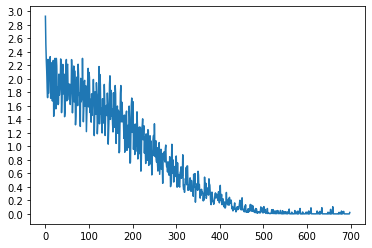

In [45]:
# train model
model_1 = trainModel(model, 
                     pairs, 
                     learning_rate=learning_rate, 
                     epochs=epochs, 
                     print_every=dataset_size)

In [50]:
def evaluate(model, source, max_trg_len=100):
    model.eval()
    with torch.no_grad():
        input_tensor = tensorFromSentence(source, vocab_questions)
        input_length = input_tensor.size()[0]
        
        decoded_words = []
        
        output = model(input_tensor, None)
        
        for ot in range(max_trg_len):
            topv, topi = output[ot].topk(1)
            
            if topi[0].item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(vocab_answers.index2word[topi[0].item()])
    
    return decoded_words

def evaluateRandomly(model, pairs=pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(f"source: {pair[0]}")
        print(f"target: {pair[1]}")
        try:
            output_words = evaluate(model, pair[0])
            output_sentence = " ".join(output_words)
            print("predicted: {}".format(output_sentence))
        except KeyError:
            print("Word not found in vocabulary")
        
def evaluateInput(model, input_sentence):
    input_sentence = input_sentence.lower()
    output_words = evaluate(model, input_sentence)
    output_sentence = " ".join(output_words)
    print("predicted: {}".format(output_sentence))

In [53]:
evaluateRandomly(model_1)

source: when were video made avail through the itun store
target: octob 12 2005
predicted: <SOS> 12 2005 <EOS>
source: chimamanda ngozi adichi vompar lee to whom
target: william faulkner
predicted: <SOS> faulkner <EOS>
source: what edict did the ming issu
target: imperi edict
predicted: <SOS> edict <EOS>
source: when did the austrian film of spectr finish
target: februari 2015
predicted: <SOS> 2015 <EOS>
source: who was station along the boarder
target: russian border troop
predicted: <SOS> border troop <EOS>
source: what year did the yongl emperor reign
target: 1402 1424
predicted: <SOS> 1424 <EOS>
source: who are the deputi prime minist
target: murodali alimardon and ruqiya qurbanova
predicted: <SOS> alimardon and ruqiya qurbanova <EOS>
source: how mani borough doe new york citi have
target: five
predicted: <SOS> <EOS>
source: which three person from previous film appear in spectr
target: m q and eve moneypenni
predicted: <SOS> q and eve moneypenni <EOS>
source: who is the develop of